In [1]:
%load_ext autoreload
%autoreload 2

import time
import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.HH.HH import HHbbWWDoubleLeptonGenDataset,HHbbWWDoubleLeptonRecoDataset
from memflow.read_data import utils
from memflow.callbacks.transfer_flow_callbacks import *

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

In [2]:
gen_data = RootData(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root',
    ],
    treenames = [
        'gen_HH;1',
    ],
    lazy = True,
    #N = 1000,
)

print (gen_data)

Data object
Loaded branches:
   ... file: 1589994
   ... sample: 1589994
   ... tree: 1589994
Branch in files not loaded:
   ... H1_E
   ... H1_Px
   ... H1_Py
   ... H1_Pz
   ... H1_eta
   ... H1_idx
   ... H1_mass
   ... H1_pdgId
   ... H1_phi
   ... H1_pt
   ... H1_sum_E
   ... H2_E
   ... H2_Px
   ... H2_Py
   ... H2_Pz
   ... H2_eta
   ... H2_idx
   ... H2_mass
   ... H2_pdgId
   ... H2_phi
   ... H2_pt
   ... H2_sum_E
   ... ISR_10_E
   ... ISR_10_Px
   ... ISR_10_Py
   ... ISR_10_Pz
   ... ISR_10_eta
   ... ISR_10_idx
   ... ISR_10_mass
   ... ISR_10_parent
   ... ISR_10_pdgId
   ... ISR_10_phi
   ... ISR_10_pt
   ... ISR_11_E
   ... ISR_11_Px
   ... ISR_11_Py
   ... ISR_11_Pz
   ... ISR_11_eta
   ... ISR_11_idx
   ... ISR_11_mass
   ... ISR_11_parent
   ... ISR_11_pdgId
   ... ISR_11_phi
   ... ISR_11_pt
   ... ISR_12_E
   ... ISR_12_Px
   ... ISR_12_Py
   ... ISR_12_Pz
   ... ISR_12_eta
   ... ISR_12_idx
   ... ISR_12_mass
   ... ISR_12_parent
   ... ISR_12_pdgId
   ... ISR_12

In [3]:
gen_dataset = HHbbWWDoubleLeptonGenDataset(
    data = gen_data,
    selection = [
        'leptons',
        'bquarks',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print (gen_dataset)

Selecting 1519507 events out of 1589994
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/hh_gen
No final state recorded with `final_states_object_name` property, will not compute PS points
Parton dataset with 1519507 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -12, -11, 12]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0, 0.0005109989499999999, 0.0]
Containing the following tensors
leptons  : data ([1519507, 4, 5]), mask ([1519507, 4])
           Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%]
           Mask corr     : [True, True, True, True]
           Weights       : 1519507.00, 1519507.00, 1519507.00, 1519507.00
           Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
           Selected for batches : True
higgs    : data ([1519507, 2, 5]), mask ([1519507, 2])
           Mask exist    : [100.00%, 100.00%]
           Mask corr     : [True, True]
           Weights       : 1519507.00, 1519507.00
 

Before preprocessing


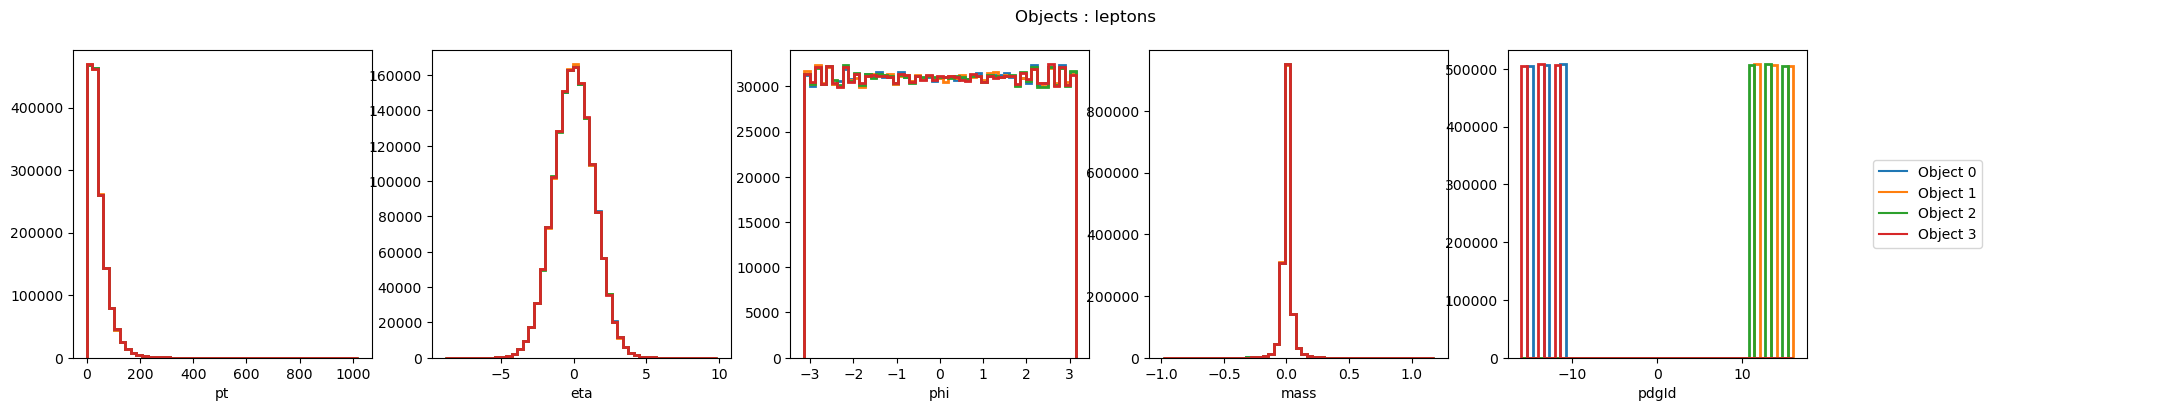

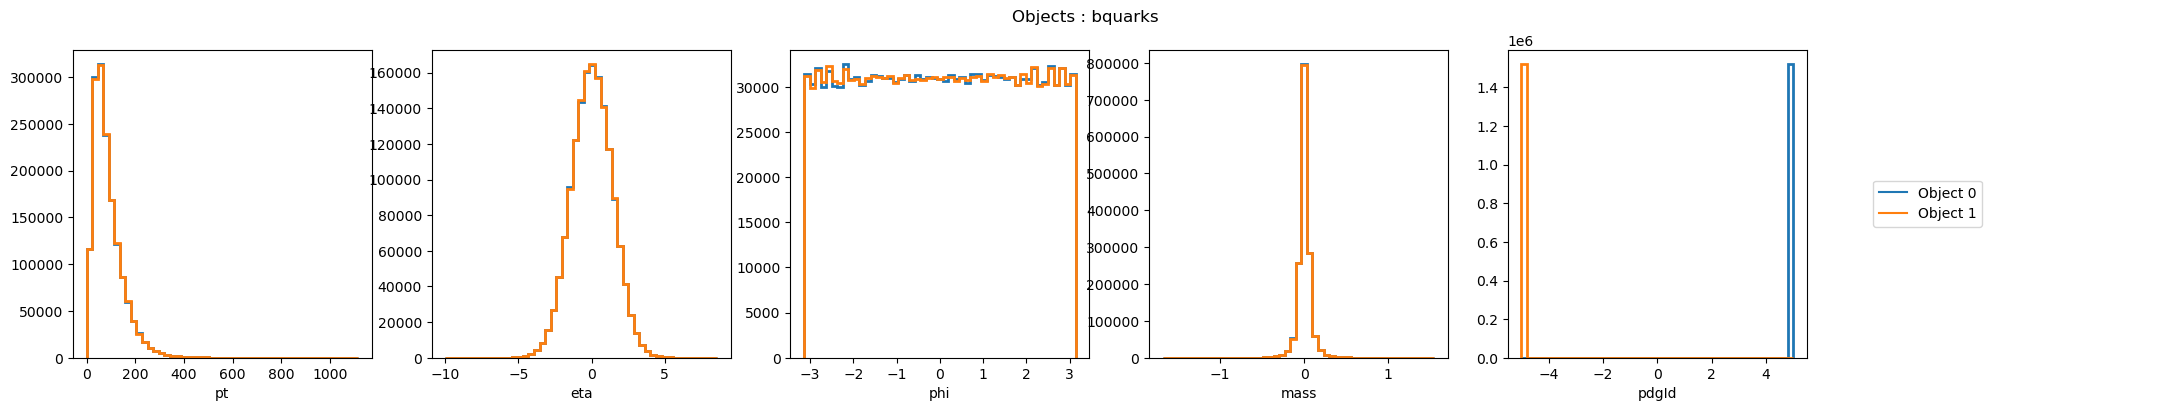

After preprocessing


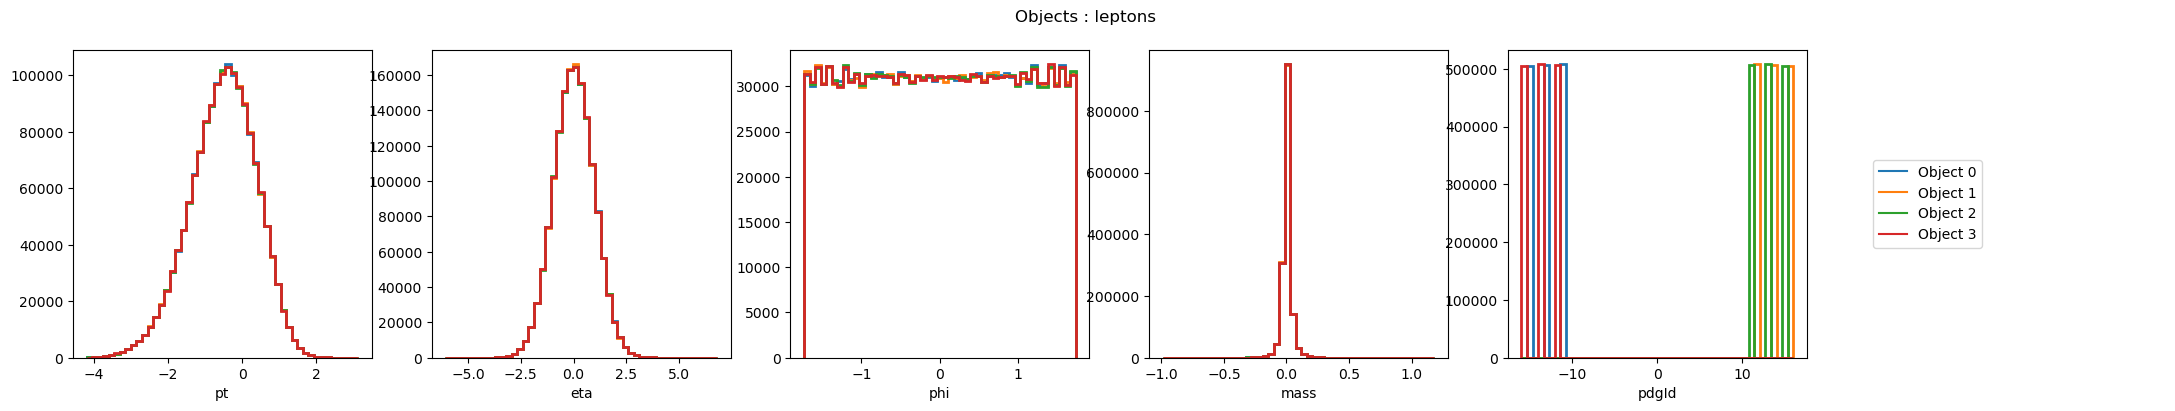

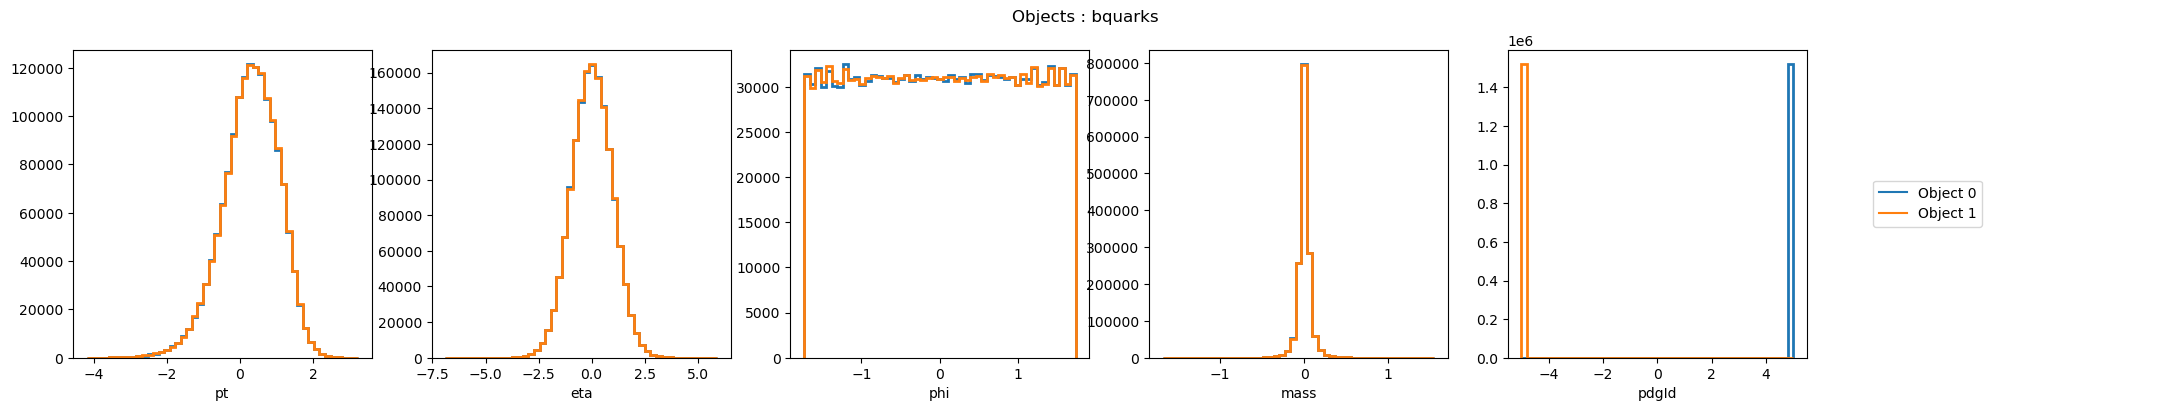

In [4]:
print ('Before preprocessing')
gen_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
gen_dataset.plot(selection=True,raw=False)

In [5]:
loader_gen = DataLoader(
    gen_dataset,
    batch_size = 32,
)
batch = next(iter(loader_gen))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

leptons torch.Size([32, 4, 5]) torch.Size([32, 4])
bquarks torch.Size([32, 2, 5]) torch.Size([32, 2])


In [6]:
reco_data = RootData(
    files = gen_data.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = gen_data.N,
)
print ('Initial :',reco_data.events)

mask_resolved = np.logical_and.reduce(
    (
        reco_data['flag_SR']==1, 
        reco_data['flag_resolved']==1,
        reco_data['n_AK4']<= 8,
    )
)
reco_data.cut(mask_resolved)
print ('Resolved SR :',reco_data.events)
print (reco_data)


Initial : 1589994
Resolved SR : 221454
Data object
Loaded branches:
   ... file: 221454
   ... flag_SR: 221454
   ... flag_resolved: 221454
   ... n_AK4: 221454
   ... sample: 221454
   ... tree: 221454
Branch in files not loaded:
   ... VBF1_E
   ... VBF1_Px
   ... VBF1_Py
   ... VBF1_Pz
   ... VBF1_eta
   ... VBF1_idx
   ... VBF1_mass
   ... VBF1_phi
   ... VBF1_pt
   ... VBF1_sel
   ... VBF2_E
   ... VBF2_Px
   ... VBF2_Py
   ... VBF2_Pz
   ... VBF2_eta
   ... VBF2_idx
   ... VBF2_mass
   ... VBF2_phi
   ... VBF2_pt
   ... VBF2_sel
   ... VBF3_E
   ... VBF3_Px
   ... VBF3_Py
   ... VBF3_Pz
   ... VBF3_eta
   ... VBF3_idx
   ... VBF3_mass
   ... VBF3_phi
   ... VBF3_pt
   ... VBF3_sel
   ... VBF4_E
   ... VBF4_Px
   ... VBF4_Py
   ... VBF4_Pz
   ... VBF4_eta
   ... VBF4_idx
   ... VBF4_mass
   ... VBF4_phi
   ... VBF4_pt
   ... VBF4_sel
   ... VBF5_E
   ... VBF5_Px
   ... VBF5_Py
   ... VBF5_Pz
   ... VBF5_eta
   ... VBF5_idx
   ... VBF5_mass
   ... VBF5_phi
   ... VBF5_pt
   ... VBF

In [6]:
reco_dataset = HHbbWWDoubleLeptonRecoDataset(
    data = reco_data,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print (reco_dataset)


KeyboardInterrupt



In [ ]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True,weighted=False)
print ('With weights')
reco_dataset.plot(selection=True,raw=False,log=True,weighted=True)

In [ ]:
loader_reco = DataLoader(
    reco_dataset,
    batch_size = 32,
)
batch = next(iter(loader_reco))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)

In [ ]:
comb_dataset = CombinedDataset(
    gen_dataset = gen_dataset,
    reco_dataset = reco_dataset,
    intersection_branch = 'event',
)
print (comb_dataset)

In [ ]:
loader_comb = DataLoader(
    comb_dataset,
    batch_size = 256,
)
batch = next(iter(loader_comb))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)
print ('Gen')
for obj,mask,sel in zip(batch['gen']['data'],batch['gen']['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

In [ ]:
idx_ee = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['electrons'],axis=1) == 2,
    ]
)
idx_mm = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['muons'],axis=1) == 2,
    ]
)
idx_em = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['electrons'],axis=1) == 1,
        ak.count(reco_data['muons'],axis=1) == 1,
    ]
)
for channel,idx in zip(['ee','mm','em'],[idx_ee,idx_mm,idx_em]):
    print (channel)
    for i in idx[:3]:
        event = comb_dataset[i]
        print ('\t idx:',i)
        print ('\t reco: ')
        for name,data,mask in zip(comb_dataset.reco_dataset.selection,event['reco']['data'],event['reco']['mask']):
            print (f'\t\t{name:15s}',data.shape,mask)
        print ('\t gen: ')
        for name,data,mask in zip(comb_dataset.reco_dataset.selection,event['gen']['data'],event['gen']['mask']):
            print (f'\t\t{name:15s}')
            print (f'\t\t',data)
            print (f'\t\t',mask)

idx_to_monitor = [idx_ee[0],idx_mm[0],idx_em[0]]
print ('Reco')
for idx in idx_to_monitor:
    print ('idx',idx)
    for data,mask,name in zip(comb_dataset[idx]['reco']['data'],comb_dataset[idx]['reco']['mask'],comb_dataset.reco_dataset.selection):
        print ('\t',name)
        print ('\t',data.shape)
        print ('\t',mask)
print ('Gen')
for idx in idx_to_monitor:
    print ('idx',idx)
    for data,mask,name in zip(comb_dataset[idx]['gen']['data'],comb_dataset[idx]['gen']['mask'],comb_dataset.gen_dataset.selection):
        print ('\t',name)
        print ('\t',data.shape)
        print ('\t',mask)


In [ ]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.8
indices = torch.arange(len(comb_dataset))
sep = int(train_frac*len(comb_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

comb_dataset_train = torch.utils.data.Subset(comb_dataset,train_indices)
comb_dataset_valid = torch.utils.data.Subset(comb_dataset,valid_indices)
print (len(comb_dataset_train),len(comb_dataset_valid))

batch_size = 1024

loader_comb_train = DataLoader(
    comb_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_comb_valid = DataLoader(
    comb_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)

In [ ]:
from memflow.transfer_flow.transfer_flow_model import TransferFlow

model = TransferFlow(
    embed_dim = 64,
    embed_act = nn.GELU,
    n_gen_particles_per_type = gen_dataset.number_particles_per_type,
    gen_particle_type_names = gen_dataset.selection,
    gen_input_features_per_type = gen_dataset.input_features,
    n_reco_particles_per_type = reco_dataset.number_particles_per_type,
    reco_particle_type_names = reco_dataset.selection,
    reco_input_features_per_type = reco_dataset.input_features,
    flow_input_features = [
        ['pt','eta','phi'], # electrons
        ['pt','eta','phi'], # muons
        ['pt','phi'],       # met
        ['pt','eta','phi'], # jets
    ],
    autoregressive_mode = 'global', # 'global', 'type' or 'particle'
    reco_mask_corr = reco_dataset.correlation_mask,
    gen_mask_corr = gen_dataset.correlation_mask,
    transformer_args = {
        'nhead' : 8,
        'num_encoder_layers' : 6, 
        'num_decoder_layers' : 6, 
        'dim_feedforward' : 256, 
        'dropout' : 0., 
        'activation' : 'gelu', 
    },
    flow_args = {
        'bins' : 32,
        'transforms' : 5,
        'randperm' : True,
        'passes' : None,
        'hidden_features' : [256] * 3,   
    },
    onehot_encoding = True,
)
model = model.cpu()

batch = next(iter(loader_comb))
log_probs, mask, weights = model(batch)
print ('log_probs',log_probs,log_probs.shape)
print ('mask',mask,mask.shape)
print ('weights',weights,weights.shape)

log_probs_tot = model.shared_eval(batch,0,'test')
print ('tot log probs',log_probs_tot)

samples = model.sample(batch['gen']['data'],batch['gen']['mask'],batch['reco']['data'],batch['reco']['mask'],N=100)
print ('samples')
for sample in samples:
    print ('\t',sample.shape)

print (model)


In [ ]:
sampling = SamplingCallback(
    dataset = comb_dataset,
    idx_to_monitor = idx_to_monitor,
    N_sample = 100000, 
    frequency = 1,
    raw = False,
    bins = 100,
    log_scale = True,
)
sampling.make_sampling_plots(model,show=True)


In [ ]:
bias = BiasCallback(
    dataset = comb_dataset,
    N_sample = 50,
    frequency = 5,
    raw = True,
    bins = 101,
    points = 20,
    log_scale = True,
    batch_size = 10000,
    N_batch = 5,
)
figs = bias.make_bias_plots(model,show=True)

In [ ]:
##### Parameters #####
epochs = 200
steps_per_epoch_train = math.ceil(len(comb_dataset_train)/loader_comb_train.batch_size)
# steps_per_epoch_valid = math.ceil(len(dataset_valid)/loader_valid.batch_size)

print (f'Training   : Batch size = {loader_comb_train.batch_size} => {steps_per_epoch_train} steps per epoch')
# print (f'Validation : Batch size = {loader_valid.batch_size} => {steps_per_epoch_valid} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-3)
model.set_optimizer(optimizer)

##### Scheduler #####
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer = optimizer, 
#     max_lr = 1e-3, 
#     epochs = epochs, 
#     steps_per_epoch = steps_per_epoch_train, 
#     pct_start = 0.20, 
#     anneal_strategy='cos', 
#     cycle_momentum=True, 
#     base_momentum=0.85, 
#     max_momentum=0.95, 
#     div_factor=1e3, 
#     final_div_factor=1e5,
# )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode='min', 
    factor=0.1, 
    patience=10, 
    threshold=0.001, 
    threshold_mode='rel', 
    cooldown=5, 
    min_lr=1e-7
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    sampling,
    bias,
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'HH',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_comb_train,
    val_dataloaders = loader_comb_valid,
)

In [ ]:
sampling = SamplingCallback(
    dataset = comb_dataset,
    idx_to_monitor = idx_to_monitor,
    N_sample = 100000, 
    frequency = 1,
    raw = True,
    bins = 101,
    log_scale = True,
)
sampling.make_sampling_plots(model,show=True)

# sampling = SamplingCallback(
#     comb_dataset = comb_dataset,
#     idx_to_monitor = idx_to_monitor,
#     N_sample = 100000, 
#     frequency = 1,
#     raw = False,
#     bins = 25,
#     log_scale = False,
# )
# sampling.make_sampling_plots(model,show=True)

In [ ]:
bias = BiasCallback(
    dataset = comb_dataset,
    N_sample = 50,
    frequency = 1,
    raw = True,
    bins = 51,
    points = 21,
    log_scale = True,
    batch_size = 10000,
)
figs = bias.make_bias_plots(model,show=True)

In [ ]:
torch.save(model,'TF.pt')